*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of generating variograms.

# Spatial Data Simulation

Let's say that you are a spatial data analyst of a gold mining company, and want to know the distribution of gold percentage over 100m x 100m mining area. To understand the characteritics of the rock formations, you take 100 random rock samples from the mining area, but obviously these 100 data points are not enough to estimate gold percentage over every single spatial locations in the area. So you analyze the available data (100 rock samples from random locations) and simulate full 2D-surface plot for gold percentage over the mining area.

![Simulation](https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/gold_transform.png?raw=true)

This 2D surface simulation from sparse spatial data is a sequential process that involves many complicated statistical techniques. 

Steps:

1. Plot experimental variogram
2. Fit variogram model
3. Apply kriging
4. Apply simulation on top of Kriging
5. Run simulation multiple times and perform additioanl data analyses as needed

In this post, the concepts, theory, and methodology of plotting a **variogram** will be covered. 


# Basics of Variograms

> **Variogram** is a measure of dissimilarity over a distance. It shows how two data points are correlated from a spatial perspective, and provides useful insights when trying to estimate the value of an unknown location using collected sample data from other locations.

[Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) states that "everything is related to everything else, but near things are more related than distant things." Variogram demonstates just that. It shows how correlation between two spatial data varies over distances. For example, terrains 1 km apart from each other are more likely to be similar than terrains 100 km apart from each other. Oil wells 500 ft apart from each other are more likely to show similar reservoir characteristics than oil wells 5000 ft apart from each other. Variogram quantifies this spatial similarity & dissimilarity over distances.

The difference between **experimental variogram** and **variogram model** should be noted. 

<img style="width: 50%" src="https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/variogram_experimental_and_model.png?raw=true"/>

=====================================figure==============================================

rough experimental variogram, and variogram model in a sigle figure. 
add legend to differentiate between model and experimental. 
Expeirmental = dotted
model = line

=========================================================================================
experimental - actual data
purpose: to decide the most optimal variogram model that best describes spatial variability

model - fitted data
purpose: to obtain value of parameters used for kriging (range, sill, nugget).

The *experimental variogram* has the following formula:

<p><center>$\gamma(h) = \frac{1}{2N(h)} \Sigma $</center></p>

Where

&nbsp;&nbsp; Gamma $(\gamma)$ = variablity of spatial data points at a lag distance (h)

&nbsp;&nbsp; Lag distance $(h)$ = distance between two data points. In geostatistics, we refer to spatial distance as *lag*.

&nbsp;&nbsp; N = number of data points

&nbsp;&nbsp; $z(u_\alpha)$ = value of interest at a location $u_\alpha$. This can be porosity, permeability, or any physical property of interest.

How is variogram c

=====================================figure==============================================

smooth variogram

=========================================================================================

Each point ($\gamma$) in a variogram is the one half the average squared difference over lag distance, *h*, over all possible pairs of data. $z(u_\alpha)$ is the **head**, and $z(u_\alpha \ + \ h)$ is the **tail**. So essentially each point in a variogram shows the difference between head and tail that are separated apart by a distance of *h*. The idea can be graphically represented like this:

=====================================figure==============================================

UPPER
((( left side )))
experimental variogram, --> use the one that i manually made.
ylabel = gamma(h)
xlabel = Lag Distance (m)
===> PAINT = annotate 10m lag distance, with upward red arrow, with annotation, h = 10m


((( right side)))
2D surface plot, color ranging from red ~ blue. 
title = 'Spatial Porosity Data'
ylabel = y(m)
xlabel = x(m)
==> PAINT = annotate 5 sets of two boxes connected by a distance of 10m, or anything.

LOWER
((( left side )))
20 m
((( right side )))
20 m
 
=========================================================================================

Although in the figure only 10 spatial data pairs were annotated, when actually calculating gamma ($\gamma$) values for variogram, all data pairs were considered. Note how a single point in variogram is obtained by performing multiple calculations for all of data points. The variogram itself may look simple, but the calculations are actually very complicated. More details about variogram calculation will be covered in the later part of this notebook.



In [19]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import typing
%matplotlib notebook

In [20]:
data = pd.read_excel('sample_data/2D_Data.xlsx', sheet_name="variogram_sample")

x = data['x']
y = data['y']
z = data['z']

<IPython.core.display.Javascript object>


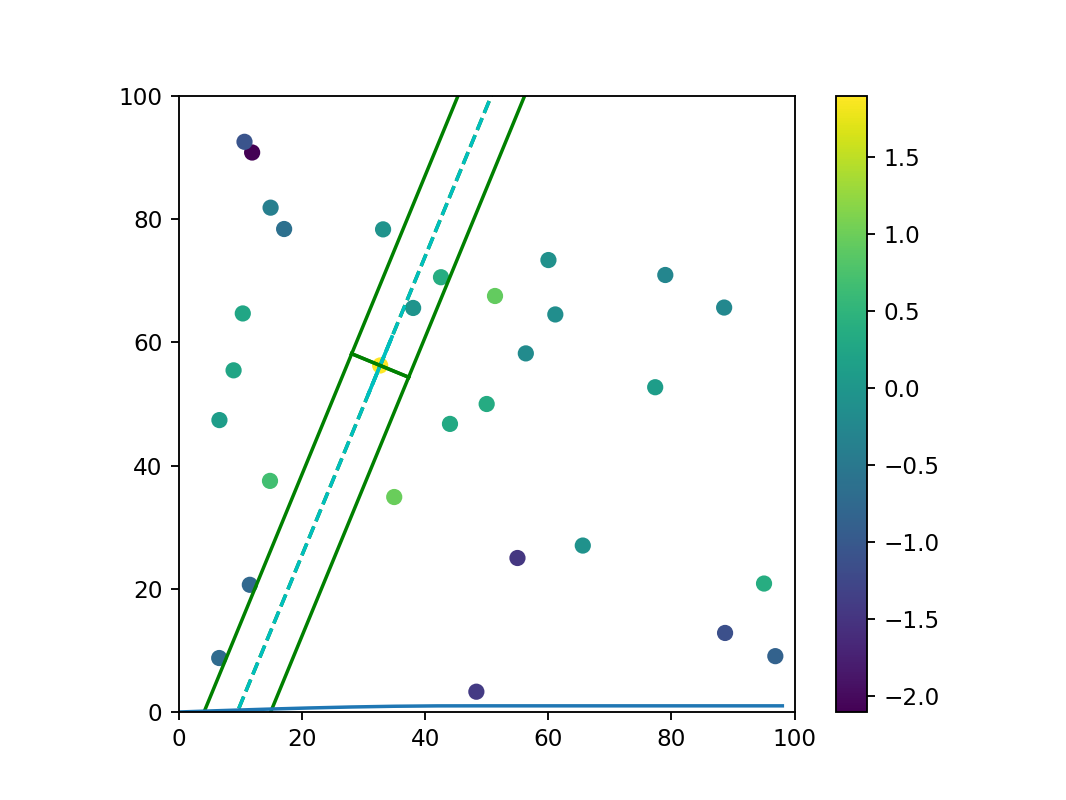

Variogram2D(dist_max=100, azi=[202.4, 202.4], lag_dist=7, azi_tol=90, lag_tol=3.5, isotropy=True)


In [21]:
class Values2D:
    def __init__(self, values=None, azimuth=None):
        self.values = values
        self.azimuth = azimuth
        
    def __repr__(self):
        return("{}(values={}, azimuth={})".format(self.__class__.__name__, self.values, self.azimuth))
    
        
class Variogram2D:

    def __init__(self, x, y, z, dist_max, azi, lag_dist, azi_tol=None, lag_tol=None, bandwidth=None):

        self.x = x
        self.y = y
        self.z = z
        
        self.dist_max = dist_max
        self.lag_dist = lag_dist
        self.bandwidth = bandwidth
        self.azi_raw = azi

        self.npair = []
        self.sumsq = []
        self.gamma = []

        # typical value of azimuth tolerance is +/- 22.5 degrees
        self.azi_tol = azi_tol if azi_tol is not None else 22.5 
        
        # typical lag tolerance is half of the lag distance
        self.lag_tol = lag_tol if lag_tol is not None else lag_dist / 2

        assert len(x) == len(y) == len(z), "x, y, and z must have the same dimension"
        assert 0 <= azi <= 360, "azimuth must have a range of [0, 360]"
        assert 0 <= self.azi_tol <= 90, "azimuth tolerance must have a range of [0, 90]"

        if azi_tol == 90:
            self.isotropy = True
        else:
            self.isotropy = False
        
        # number of data points
        self.n = len(x)

        # lag distance bins on which variogram gamma values will be computed
        self.lags = np.array([i * lag_dist for i in range(int(dist_max / lag_dist) + 1)])

        # 1-D distances between two points on a coordinate system
        self.dx = np.array([[x[i] - x[j] for j in range(self.n)] for i in range(self.n)])
        self.dy = np.array([[y[i] - y[j] for j in range(self.n)] for i in range(self.n)])

        # 2-D distances between two data points on a coordinate system
        self.distances = np.array(
            [[np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2) for j in range(self.n)] for i in range(self.n)])

        # difference in angle between two data points (degrees)
        self.dazimuth = np.array([[self.calc_theta(i, j) for j in range(self.n)] for i in range(self.n)])

        # squared differences between two data points values at a certain lag distance
        self.pairwise_sq_diff = np.array([[(z[i] - z[j]) ** 2 for j in range(self.n)] for i in range(self.n)])

        # user defined azimuth in two directions. In case of isotropy, azimuth is the same for both directions
        if self.isotropy:
            self.azi = [self.ensure_positive_azimuth(azi), self.ensure_positive_azimuth(azi)]
        else:
            self.azi = [self.ensure_positive_azimuth(azi), self.ensure_positive_azimuth(azi + 90)]

        # variogram gamma values in two directions. They are the same for both directions in case of isotropy
        self.directional_compute()

    # ensures positive azimuth between two data points.
    # In variograms, positive y-axis of a 2-D plane is 0 degree azimuth. Azimuth increases clockwise
    def ensure_positive_azimuth(self, azi):
        if azi + self.azi_tol > 360:
            return azi - 180
        elif azi - self.azi_tol < 0:
            return azi + 180
        else:
            return azi

    def calc_theta(self, i, j):
        if self.dx[i, j] > 0:
            theta = np.degrees(np.pi / 2 - np.arctan(self.dy[i, j] / self.dx[i, j]))
        elif self.dx[i, j] < 0:
            theta = np.degrees(np.pi * 1.5 - np.arctan(self.dy[i, j] / self.dx[i, j]))
        else:
            if self.dy[i, j] > 0:
                theta = 0
            elif self.dy[i, j] < 0:
                theta = 180
            else:
                theta = 0
        return theta

    def is_within_azi_lag_tolerance(self, data_azi, data_lag, lag, azi):
        is_azi_tolerated = azi - self.azi_tol <= data_azi <= azi + self.azi_tol
        is_lag_tolerated = lag - self.lag_tol <= data_lag <= lag + self.lag_tol
        return is_azi_tolerated and is_lag_tolerated
    
    def is_within_bandwidth(self):
        ()

    def calc_npairs(self, lag, azi):
        npairs = 0
        for i in range(self.n):
            for j in range(self.n):
                if self.is_within_azi_lag_tolerance(self.dazimuth[i, j], self.distances[i, j], lag, azi):
                    npairs += 1
        return npairs

    def calc_sumsq(self, lag, azi):
        sumsq = 0
        for i in range(self.n):
            for j in range(self.n):
                if self.is_within_azi_lag_tolerance(self.dazimuth[i, j], self.distances[i, j], lag, azi):
                    sumsq += self.pairwise_sq_diff[i, j]
        return sumsq

    def directional_compute(self):
        for i in range(2):
            npair = Values2D()
            sumsq = Values2D()
            gamma = Values2D()

            npair.values = np.array([self.calc_npairs(lag, self.azi[i]) for lag in self.lags])
            sumsq.values = np.array([self.calc_sumsq(lag, self.azi[i]) for lag in self.lags])
            gamma.values = np.divide(sumsq.values, npair.values * 2)

            npair.azimuth = self.azi[i]
            sumsq.azimuth = self.azi[i]
            gamma.azimuth = self.azi[i]

            self.npair.append(npair)
            self.sumsq.append(sumsq)
            self.gamma.append(gamma)    
            
        # add z-value implementation later
            
    def plot_sparse(self, ax=None, **kwargs):
        
        if ax is None:
            fig, ax = plt.subplots()
            
        x = self.x
        y = self.y

        assert len([x]) == len([y]), "x and y must have the same dimension"
            
        sc = ax.scatter(x, y, c=self.z, **kwargs)
        ax.set_aspect("equal")
        ax.set_xlim(0, self.dist_max)
        ax.set_ylim(0, self.dist_max)
        
        return sc

    
    def plot_search_template(self, point=None, ax=None):
        
        if ax is None:
            fig, ax = plt.subplots()
        if point is None:
            random_index = np.random.randint(0, len(self.x))
            point = (self.x[random_index], self.y[random_index])
            
        assert type(point) is tuple and len(point)==2, "point must be a tuple of length 2"
        
        x, y = point
        
        if ax is None:
            ax = self.plot_sparse(ax)
        
        # longest possible line in the plot = diagonal line
        length = np.sqrt(2) * self.dist_max
        
        # first = major-axis, second = minor-axis
        azi_linestyles = ['g--', 'c--']    
        tol_linestyles = ['g', 'c']
        
        # azimuth direction
        x_azi = []
        y_azi = []
        for angle, style in zip(self.azi, azi_linestyles):          
            x1 = x - length * math.cos(math.radians(90 - angle))
            y1 = y - length * math.sin(math.radians(90 - angle))
            x2 = x + length * math.cos(math.radians(90 - angle))
            y2 = y + length * math.sin(math.radians(90 - angle))        
            ax.plot([x1, x2], [y1, y2], style)
            
            # values used to draw tolerance line with bandwidth. Not used if there's no bandwidth
            x_azi.extend((x1, x2))
            y_azi.extend((y1, y2))
        
        # +/- azimuth tolereance direction
        if self.bandwidth is None:
            for tol in [self.azi_tol, -self.azi_tol]:
                for angle, style in zip(self.azi, tol_linestyles):
                    x1 = x - length * math.cos(math.radians(90 - angle + tol))
                    y1 = y - length * math.sin(math.radians(90 - angle + tol))
                    x2 = x + length * math.cos(math.radians(90 - angle + tol))
                    y2 = y + length * math.sin(math.radians(90 - angle + tol))     
                    ax.plot([x1, x2], [y1, y2], style)
        else:
            # h is hypotenuse of a triangle of azimuth extension, azimuth tolerance extension, and bandwidth
            h = self.bandwidth / math.sin(math.radians(self.azi_tol))
            x_band = []
            y_band = []
            for perpendicular in [0, 90, 180, 270]:
                for tol in [self.azi_tol, -self.azi_tol]:
                    x_band.append(x + h * math.cos(math.radians(perpendicular - self.azi[0] + tol)))
                    y_band.append(y + h * math.sin(math.radians(perpendicular - self.azi[0] + tol)))
            
            # azimuth tolerance plot with bandwidth
            # this part was hard-coded because its difficult to do it otherwise. 
            # it's ok to do it this way, because there's always 8 lines to be plotted
            for i in range(2):
                ax.plot([x_band[i], x_band[i + 4]], [y_band[i], y_band[i + 4]], tol_linestyles[1])
            for i in range(2, 4):
                ax.plot([x_band[i], x_band[i + 4]], [y_band[i], y_band[i + 4]], tol_linestyles[0])
            for i in range(8):
                # minor-axis
                if self.azi_raw < self.azi_tol:
                    if i == 0 or i == 1:
                        xnew = x_band[i-4] + length * math.cos(math.radians(90 - self.azi[1]))
                        ynew = y_band[i-4] + length * math.sin(math.radians(90 - self.azi[1]))
                        #ax.plot([x_band[i-4], xnew], [y_band[i-4], ynew], tol_linestyles[1])
                    elif i == 4 or i == 5:
                        xnew = x_band[i-7] - length * math.cos(math.radians(90 - self.azi[1]))
                        ynew = y_band[i-7] - length * math.sin(math.radians(90 - self.azi[1]))
                        #ax.plot([x_band[i-4], xnew], [y_band[i-4], ynew], tol_linestyles[1])
                else:
                    if i == 0 or i == 1:
                        xnew = x_band[i] + length * math.cos(math.radians(90 - self.azi[1]))
                        ynew = y_band[i] + length * math.sin(math.radians(90 - self.azi[1]))
                        ax.plot([x_band[i], xnew], [y_band[i], ynew], tol_linestyles[1])
                    elif i == 4 or i == 5:
                        xnew = x_band[i] - length * math.cos(math.radians(90 - self.azi[1]))
                        ynew = y_band[i] - length * math.sin(math.radians(90 - self.azi[1]))
                        ax.plot([x_band[i], xnew], [y_band[i], ynew], tol_linestyles[1])                    
                
                # major-axis
                if i == 2 or i == 3:
                    xnew = x_band[i] + length * math.cos(math.radians(90 - self.azi[0]))
                    ynew = y_band[i] + length * math.sin(math.radians(90 - self.azi[0]))  
                    ax.plot([x_band[i], xnew], [y_band[i], ynew], tol_linestyles[0])
                elif i == 6 or i == 7:
                    xnew = x_band[i] - length * math.cos(math.radians(90 - self.azi[0]))
                    ynew = y_band[i] - length * math.sin(math.radians(90 - self.azi[0]))    
                    ax.plot([x_band[i], xnew], [y_band[i], ynew], tol_linestyles[0])
                    
        return ax

            
    def __repr__(self):
        return("{}(dist_max={}, azi={}, lag_dist={}, azi_tol={}, lag_tol={}, isotropy={})".format(self.__class__.__name__, self.dist_max, self.azi, self.lag_dist, self.azi_tol, self.lag_tol, self.isotropy))
    
data = pd.read_excel('sample_data/2D_Data.xlsx', sheet_name="variogram_sample")
x = data['x']
y = data['y']
z = data['z'] 

fig, ax = plt.subplots()

temp = Variogram2D(x, y, z, dist_max=100, azi=22.4, azi_tol=90, lag_dist=7, bandwidth=5)
sc = temp.plot_sparse(ax=ax)
fig.colorbar(sc)

temp.plot_search_template(ax=ax)
print(temp)


data

C:\Users\EricKim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


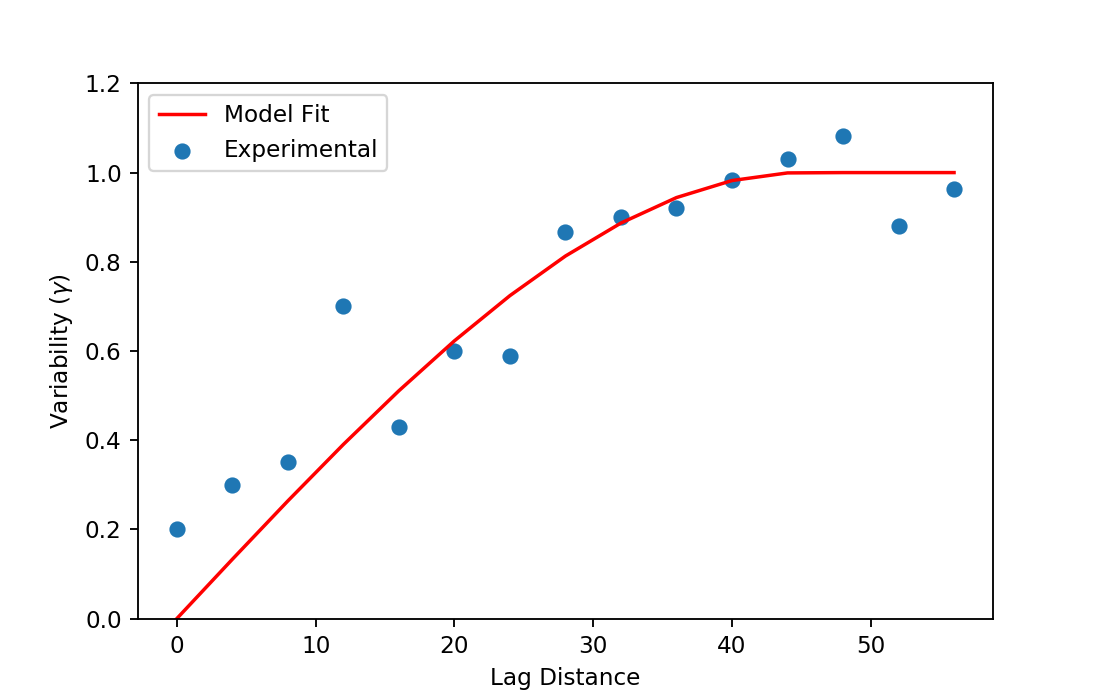

Values2D(values=[0.2, 0.3, 0.35, 0.7, 0.43, 0.6, 0.5894681426648509, 0.8662199039136801, 0.9, 0.92, 0.9842161125803545, 1.0314295297710225, 1.0811755272262884, 0.88, 0.9628724706336579], azimuth=170)


In [24]:

x = data['x']
y = data['y']
z = data['z'] 

def calc_y(c1, h, a, sill):
    if h > a:
        return c1 + sill
    return c1 + sill * (1.5 * h / a - 0.5 * (h / a) ** 3)

new_lags = temp.lags[:15]

fit = [calc_y(0, lag, 45, 1) for lag in new_lags]
ax.plot(temp.lags[:15], fit)

temp = Variogram2D(x, y, z, dist_max=100, azi=80, azi_tol=22.5, lag_dist=4, lag_tol=7.5)

fig, ax = plt.subplots()

temp.gamma[1].values = [item - 0.1 for item in temp.gamma[1].values][:15]
temp.gamma[1].values[0] = 0.2
temp.gamma[1].values[1] = 0.3
temp.gamma[1].values[2] = 0.35
temp.gamma[1].values[3] = 0.7
temp.gamma[1].values[4] = 0.43
temp.gamma[1].values[5] = 0.6
temp.gamma[1].values[8] = 0.9
temp.gamma[1].values[9] = 0.92


temp.gamma[1].values[-5:] = [item - 0.15 for item in temp.gamma[1].values[-5:]]
temp.gamma[1].values[13] = 0.88

ax.scatter(temp.lags[:15], temp.gamma[1].values[:15], label='Experimental')
ax.set_ylim(0, 1.2)
ax.set_xlabel('Lag Distance')
ax.set_ylabel('Variability ($\gamma$)')

print(temp.gamma[1])
ax.plot(temp.lags[:15], fit, color='red', label='Model Fit')
ax.legend()
plt.savefig('variogram_experimental_and_model.png')

In [84]:
print(new_lags)

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56]


C:\Users\EricKim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


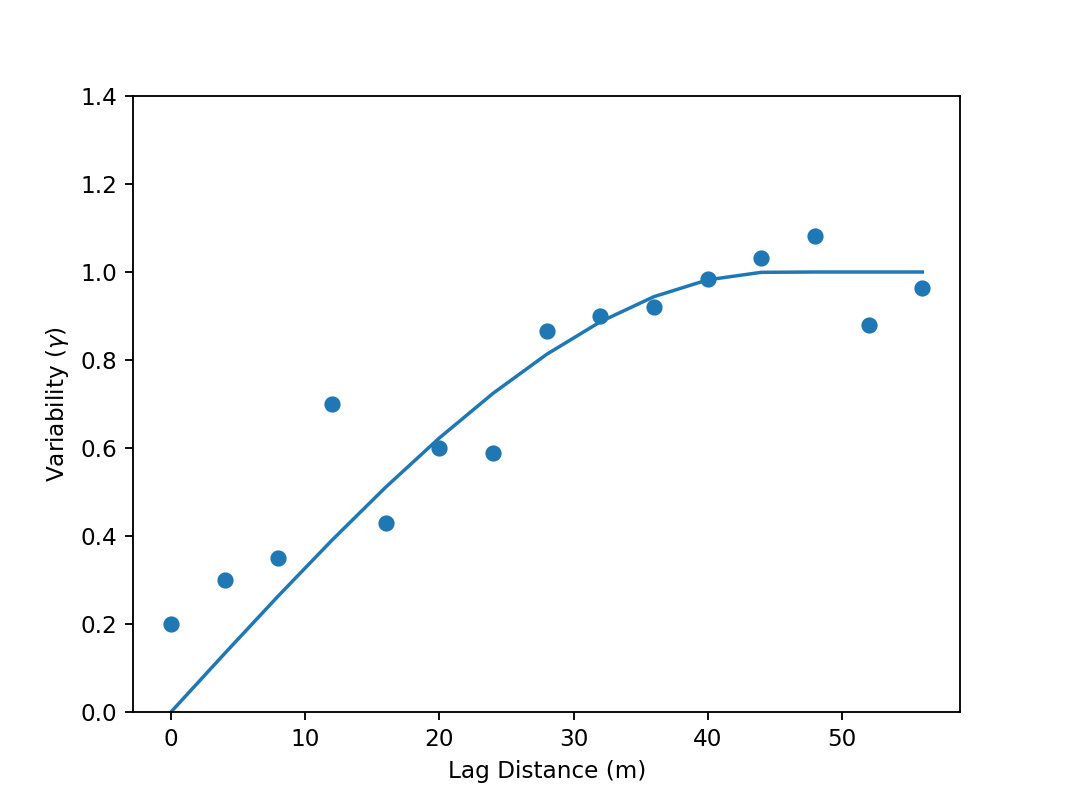

Values2D(values=[0.2, 0.3, 0.35, 0.7, 0.43, 0.6, 0.5894681426648509, 0.8662199039136801, 0.9, 0.92, 0.9842161125803545, 1.0314295297710225, 1.0811755272262884, 0.88, 0.9628724706336579], azimuth=170)


In [16]:
x = data['x']
y = data['y']
z = data['z'] 


temp = Variogram2D(x, y, z, dist_max=100, azi=80, azi_tol=22.5, lag_dist=4, lag_tol=7.5)

fig, ax = plt.subplots()

temp.gamma[1].values = [item - 0.1 for item in temp.gamma[1].values][:15]
temp.gamma[1].values[0] = 0.2
temp.gamma[1].values[1] = 0.3
temp.gamma[1].values[2] = 0.35
temp.gamma[1].values[3] = 0.7
temp.gamma[1].values[4] = 0.43
temp.gamma[1].values[5] = 0.6
temp.gamma[1].values[8] = 0.9
temp.gamma[1].values[9] = 0.92

temp.gamma[1].values[-5:] = [item - 0.15 for item in temp.gamma[1].values[-5:]]
temp.gamma[1].values[13] = 0.88

ax.scatter(temp.lags[:15], temp.gamma[1].values[:15])
ax.set_ylim(0, 1.4)
ax.set_xlabel('Lag Distance (m)')
ax.set_ylabel('Variability ($\gamma$)')

print(temp.gamma[1])
ax.plot(temp.lags[:15], fit)